# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, desc, lit, min, max, split, udf, sum, when
from pyspark.sql.types import *
from datetime import datetime 
import time
import warnings
warnings.filterwarnings('ignore')
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.mllib.tree import DecisionTree

from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Predicting churn using Pyspark ML") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
events = spark.read.json('mini_sparkify_event_data.json')

In [4]:
#checking the first 5 rows from the dataset
#using pandas to print the dataframe in a more readable format
pd.DataFrame(events.take(5), columns=events.columns).transpose()

,0,1,2,3,4
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert,Enigma,Daft Punk
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin,Micah,Colin
gender,M,M,M,M,M
itemInSession,50,79,51,80,52
lastName,Freeman,Long,Freeman,Long,Freeman
length,277.89,236.094,282.827,262.713,223.608
level,paid,free,paid,free,paid
location,"Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA"
method,PUT,PUT,PUT,PUT,PUT


In [5]:
#checking count of rows for one user
events.where(col("userId") == 30).count()

1775

In [6]:
#let's check for one user, how many different records are there?
events.where(col("userId") == 30).show(100)

+--------------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|        Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|Bakersfield, CA|   PUT| 

In [7]:
#printing the column details
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
#Page column contains useful information about the user's activity
events.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [9]:
#total records in the event dataset
events.count()

286500

In [10]:
#Let's check if there are any missing sessionid's or not
events.where(col('sessionId').isNull()).count()

0

In [11]:
#Let's check if there are some missing userid's or not
events.where(col('userId').isNull()).distinct().count()

0

In [12]:
#Let's check if there are any userId as blank, mostly meaning guest users, so no need to keep them in our analysis.
events.where(col('userId') == '').count()

8346

In [13]:
#let's convert ts to timestamp column for some exploratory data analysis and also creating a hour column
#these below 2 user defined functions will be applied to the dataset below
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
get_hour = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).hour)

In [14]:
#applying the functions and creating 2 new columns
events  = events.withColumn("datetime", get_timestamp(events.ts))
events = events.withColumn("hourofday", get_hour(events.ts))
events.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', datetime='2018-10-01 00:01:57', hourofday='0'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', datetime='2018-10-01 00:03:00', hourofday='0')]

In [15]:
#only keeping relevant columns for the analysis
events_subset = events.select('sessionId','userId','artist','auth','gender','length','level','location','page','song','datetime', 'hourofday')

In [16]:
#let's remove the blank userId entries from the dataset
valid_events = events_subset.where(col('userId') != '')

In [17]:
valid_events.count()

278154

>We have removed the userId with ''.

In [18]:
#printing first 5 rows
pd.DataFrame(valid_events.take(5), columns = valid_events.columns)

,sessionId,userId,artist,auth,gender,length,level,location,page,song,datetime,hourofday
0,29,30,Martha Tilston,Logged In,M,277.89016,paid,"Bakersfield, CA",NextSong,Rockpools,2018-10-01 00:01:57,0
1,8,9,Five Iron Frenzy,Logged In,M,236.09424,free,"Boston-Cambridge-Newton, MA-NH",NextSong,Canada,2018-10-01 00:03:00,0
2,29,30,Adam Lambert,Logged In,M,282.82730,paid,"Bakersfield, CA",NextSong,Time For Miracles,2018-10-01 00:06:34,0
3,8,9,Enigma,Logged In,M,262.71302,free,"Boston-Cambridge-Newton, MA-NH",NextSong,Knocking On Forbidden Doors,2018-10-01 00:06:56,0
4,29,30,Daft Punk,Logged In,M,223.60771,paid,"Bakersfield, CA",NextSong,Harder Better Faster Stronger,2018-10-01 00:11:16,0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
#Let's filter the dataframe with Cancellation events
pd.DataFrame(valid_events.filter("page == 'Cancellation Confirmation'").take(5), columns = valid_events.columns)

,sessionId,userId,artist,auth,gender,length,level,location,page,song,datetime,hourofday
0,514,18,None,Cancelled,M,None,paid,"Kansas City, MO-KS",Cancellation Confirmation,None,2018-10-07 20:26:30,20
1,540,32,None,Cancelled,M,None,paid,"Phoenix-Mesa-Scottsdale, AZ",Cancellation Confirmation,None,2018-10-08 21:10:46,21
2,174,125,None,Cancelled,M,None,free,"Corpus Christi, TX",Cancellation Confirmation,None,2018-10-12 04:35:18,4
3,508,105,None,Cancelled,M,None,paid,"Indianapolis-Carmel-Anderson, IN",Cancellation Confirmation,None,2018-10-12 20:17:21,20
4,797,17,None,Cancelled,F,None,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Cancellation Confirmation,None,2018-10-13 21:19:44,21


In [20]:
#How many records are there with active status?
valid_events.filter("page != 'Cancellation Confirmation'").select('userId').distinct().count()

225

In [21]:
#How many records are there with cancelled status?
valid_events.filter("page == 'Cancellation Confirmation'").select('userId').distinct().count()

52

In [22]:
#Let's explore the churned data
churned_events = valid_events.where('page == "Cancellation Confirmation"')

In [23]:
churned_events.select(['userId','artist','page','song', 'level','datetime']).show()

+------+------+--------------------+----+-----+-------------------+
|userId|artist|                page|song|level|           datetime|
+------+------+--------------------+----+-----+-------------------+
|    18|  null|Cancellation Conf...|null| paid|2018-10-07 20:26:30|
|    32|  null|Cancellation Conf...|null| paid|2018-10-08 21:10:46|
|   125|  null|Cancellation Conf...|null| free|2018-10-12 04:35:18|
|   105|  null|Cancellation Conf...|null| paid|2018-10-12 20:17:21|
|    17|  null|Cancellation Conf...|null| paid|2018-10-13 21:19:44|
|   143|  null|Cancellation Conf...|null| free|2018-10-15 07:34:14|
|   101|  null|Cancellation Conf...|null| paid|2018-10-16 22:30:37|
|   129|  null|Cancellation Conf...|null| paid|2018-10-17 00:29:21|
|   121|  null|Cancellation Conf...|null| paid|2018-10-17 07:02:29|
|    51|  null|Cancellation Conf...|null| paid|2018-10-17 07:39:32|
|    87|  null|Cancellation Conf...|null| paid|2018-10-20 15:49:16|
|   122|  null|Cancellation Conf...|null| paid|2

In [24]:
#let's see the detailed data for 1 user
valid_events.where("userId == 18").select(['userId','artist','page','song', 'level','datetime']).collect()

[Row(userId='18', artist=None, page='Home', song=None, level='paid', datetime='2018-10-02 17:05:17'),
 Row(userId='18', artist='Mike And The Mechanics', page='NextSong', song='A Beggar On A Beach Of Gold', level='paid', datetime='2018-10-02 17:05:33'),
 Row(userId='18', artist='Taking Back Sunday', page='NextSong', song='...slowdance On The Inside (Album Version)', level='paid', datetime='2018-10-02 17:10:08'),
 Row(userId='18', artist='Beirut', page='NextSong', song='St. Apollonia', level='paid', datetime='2018-10-02 17:14:36'),
 Row(userId='18', artist='Bob Log III', page='NextSong', song='Drunk Stripper', level='paid', datetime='2018-10-02 17:17:34'),
 Row(userId='18', artist='Krisiun', page='NextSong', song='In League With Satan', level='paid', datetime='2018-10-02 17:20:42'),
 Row(userId='18', artist=None, page='Settings', song=None, level='paid', datetime='2018-10-02 17:20:56'),
 Row(userId='18', artist='HYPOCRISY', page='NextSong', song='The Quest', level='paid', datetime='2018-

>As we can see this particular user, spends quite some time in the system as a Paid user before ultimately ending his subscription.
Even in some cases, they continue to use the services as a free user. Our goal will be to predict this event of cancelling or
ending the subscription.

In [25]:
#let's create a churn flag column, where some user has already cancelled the services. In order to do the same we will first
#need to find out the users who churned from the system.
users_who_churned = valid_events.where(valid_events.auth=="Cancelled").select("userId").distinct()

#creating a list of users who churned
churned_users_list = [(row['userId']) for row in users_who_churned.collect()]

#assigning 1 to the event of churn, 0 otherwise.
valid_events_withchurn = valid_events.withColumn("churned", when(col("userId").isin(churned_users_list),1).otherwise(0))

In [26]:
valid_events_withchurn.count()

278154

In [27]:
#see the columns available in the dataset after adding the churn column
valid_events_withchurn.printSchema()

root
 |-- sessionId: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- song: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- hourofday: string (nullable = true)
 |-- churned: integer (nullable = false)



In [28]:
#checking count of users churned/ non-churned
valid_events_withchurn.select(['userId','churned']).distinct().groupBy('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



>As we can see, we have successfully added the churned column to the dataset. The churned column takes 0,1 as values, and as 
the source data suggest, one user might have both the stautus. Hence we will look towards creating some features for our analysis. Before that, we will do some EDA on the dataset. 

**Songs played per hour irrespective of churned**

In [29]:
songs_played_hour = valid_events_withchurn.filter("page == 'NextSong'").groupBy("hourofday").count().orderBy(valid_events_withchurn.hourofday.cast("float"))

In [30]:
songs_played_hour.show()

+---------+-----+
|hourofday|count|
+---------+-----+
|        0| 9062|
|        1| 8388|
|        2| 8336|
|        3| 8355|
|        4| 8147|
|        5| 8178|
|        6| 8054|
|        7| 8091|
|        8| 8253|
|        9| 8498|
|       10| 8882|
|       11| 8830|
|       12| 9326|
|       13| 9644|
|       14|10494|
|       15|11354|
|       16|11636|
|       17|11460|
|       18|11124|
|       19|10930|
+---------+-----+
only showing top 20 rows



In [31]:
#converting to pandas for plotting
songs_played_hour = songs_played_hour.toPandas()
songs_played_hour

,hourofday,count
0,0,9062
1,1,8388
2,2,8336
3,3,8355
4,4,8147
5,5,8178
6,6,8054
7,7,8091
8,8,8253
9,9,8498


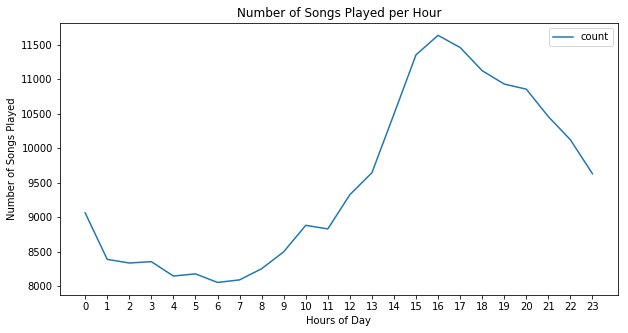

In [32]:
songs_played_hour.plot(kind = "line", figsize= (10,5))
plt.xticks(np.arange(0,24,1))
plt.xlabel("Hours of Day")
plt.ylabel("Number of Songs Played")
plt.title("Number of Songs Played per Hour")
plt.show()

> This trend shows the count of songs played in different hours of the day. And it is maximum between 4 to 5 P.M.

<h4>EDA using Churned column </h4>

**Average Length per session**

In [33]:
valid_events_withchurn.groupBy('churned').avg('length').show()

+-------+------------------+
|churned|       avg(length)|
+-------+------------------+
|      1|248.63279564406366|
|      0|249.20913538881427|
+-------+------------------+



> We can not see much difference between average length of sessions for both set of users.

**Churned by Gender**

In [34]:
valid_events_withchurn.select(['userId', 'gender', 'churned']).distinct().groupBy(['churned','gender']).count().sort('churned').show()

+-------+------+-----+
|churned|gender|count|
+-------+------+-----+
|      0|     M|   89|
|      0|     F|   84|
|      1|     F|   20|
|      1|     M|   32|
+-------+------+-----+



In [35]:
#we can plot the above graph to see the results
churned_gender = valid_events_withchurn.select(['userId', 'gender', 'churned']).distinct().groupBy(['churned','gender']).count().sort('churned').toPandas()

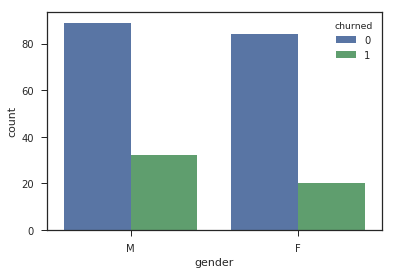

In [36]:
sns.set(style="ticks", color_codes=True)
sns.barplot(x="gender", y="count", hue="churned", data=churned_gender);

**Checking the count of churned users per level**

In [37]:
#we know there are 2 distinct levels for users
valid_events_withchurn.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [38]:
#checking the count for 2 different types
valid_events_withchurn.select(['userId', 'level', 'churned']).distinct().groupBy(['churned','level']).count().sort('churned').show()

+-------+-----+-----+
|churned|level|count|
+-------+-----+-----+
|      0| free|  149|
|      0| paid|  129|
|      1| paid|   36|
|      1| free|   46|
+-------+-----+-----+



In [39]:
#converting into a pandas dataframe
churned_levels= valid_events_withchurn.select(['userId', 'level', 'churned']).distinct().groupBy(['churned','level']).count().sort('churned').toPandas()

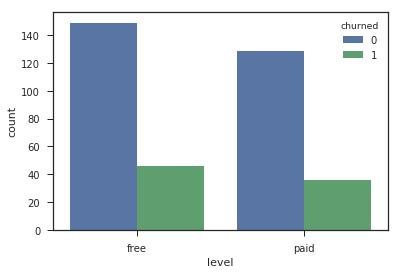

In [40]:
#plotting with seaborn
sns.set(style="ticks", color_codes=True)
sns.barplot(x="level", y="count", hue="churned", data=churned_levels);

**Session Activity**

In [41]:
#converting into a pandas dataframe
activity= valid_events_withchurn.select(['userId', 'sessionId', 'churned']).distinct().groupBy('churned').count().sort('churned').toPandas()
activity

,churned,count
0,0,2639
1,1,537


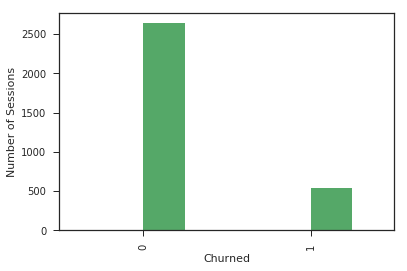

In [42]:
activity.plot(kind="bar", legend=False);
plt.xlabel("Churned")
plt.ylabel("Number of Sessions")
plt.show()

**Number of songs played**

In [43]:
valid_events_withchurn.where('page="NextSong"').select(['userId', 'churned']).distinct().groupBy('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



>We explored many interesting data trends in the above section, and looked at the relationship between churned and active users. Now, in order to build our churn prediction model, we need to define certain features for our dataset, which we would
be doing next.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**Total number of songs played**

In [44]:
total_songs_played = valid_events_withchurn.filter("page == 'NextSong'").groupBy("userId").count()
total_songs_played = total_songs_played.withColumnRenamed('count', 'total_songs_played')
total_songs_played.show()

+------+------------------+
|userId|total_songs_played|
+------+------------------+
|100010|               275|
|200002|               387|
|   125|                 8|
|    51|              2111|
|   124|              4079|
|     7|               150|
|    54|              2841|
|    15|              1914|
|   155|               820|
|   132|              1928|
|   154|                84|
|100014|               257|
|   101|              1797|
|    11|               647|
|   138|              2070|
|300017|              3632|
|    29|              3028|
|    69|              1125|
|100021|               230|
|    42|              3573|
+------+------------------+
only showing top 20 rows



**Total number of days in the system**

In [45]:
#First calculated the min_date and max_date for an user in the system
date_user = valid_events_withchurn.select(['userId','datetime']).groupBy('userID').agg(
    min(col("datetime")).alias("min_date"), max(col("datetime")).alias("max_date") )
date_user.show()

+------+-------------------+-------------------+
|userID|           min_date|           max_date|
+------+-------------------+-------------------+
|100010|2018-10-08 12:58:54|2018-11-21 18:12:32|
|200002|2018-10-01 11:30:30|2018-11-15 23:25:54|
|   125|2018-10-12 04:05:44|2018-10-12 04:35:18|
|   124|2018-10-01 15:17:10|2018-11-30 15:12:46|
|    51|2018-10-01 12:57:12|2018-10-17 07:39:32|
|     7|2018-10-03 11:57:49|2018-11-23 06:46:51|
|    15|2018-10-01 10:23:35|2018-11-25 04:56:58|
|    54|2018-10-01 00:32:10|2018-11-12 19:40:08|
|   155|2018-11-02 15:56:25|2018-11-28 11:48:30|
|100014|2018-10-10 13:12:16|2018-11-20 19:04:09|
|   132|2018-10-02 08:59:56|2018-11-21 20:56:12|
|   154|2018-11-02 15:15:35|2018-11-27 14:56:05|
|   101|2018-10-01 01:50:05|2018-10-16 22:30:37|
|    11|2018-10-05 03:20:29|2018-11-27 09:08:22|
|   138|2018-10-05 22:08:54|2018-11-30 23:59:25|
|300017|2018-10-01 13:14:06|2018-11-29 15:58:07|
|100021|2018-10-11 00:04:35|2018-11-25 11:03:02|
|    29|2018-10-01 2

In [46]:
#Then calculated the date difference between the two dates in Day's
date_user = date_user.withColumn("total_number_of_days", F.datediff(col("max_date"), col("min_date")))
date_user.sort("total_number_of_days", ascending=False).show()

+------+-------------------+-------------------+--------------------+
|userID|           min_date|           max_date|total_number_of_days|
+------+-------------------+-------------------+--------------------+
|300011|2018-10-01 21:48:13|2018-12-01 00:00:11|                  61|
|     9|2018-10-01 00:03:00|2018-11-30 14:19:12|                  60|
|200023|2018-10-01 11:37:50|2018-11-30 22:35:49|                  60|
|    81|2018-10-01 16:41:46|2018-11-30 23:56:13|                  60|
|    93|2018-10-01 15:48:39|2018-11-30 23:43:25|                  60|
|    38|2018-10-01 20:18:36|2018-11-30 19:33:21|                  60|
|   140|2018-10-01 15:02:07|2018-11-30 19:33:12|                  60|
|    92|2018-10-01 12:41:10|2018-11-30 23:34:25|                  60|
|300015|2018-10-01 19:17:53|2018-11-30 16:53:06|                  60|
|   120|2018-10-01 11:29:39|2018-11-30 01:08:23|                  60|
|    95|2018-10-01 04:21:42|2018-11-30 15:27:24|                  60|
|    30|2018-10-01 0

In [47]:
#Joing the two features together to build our final features dataframe
features = total_songs_played.join(date_user.select(['userId','total_number_of_days']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+
|userId|total_songs_played|total_number_of_days|
+------+------------------+--------------------+
|100010|               275|                  44|
|200002|               387|                  45|
|   125|                 8|                   0|
|    51|              2111|                  16|
|   124|              4079|                  60|
|     7|               150|                  51|
|    54|              2841|                  42|
|    15|              1914|                  55|
|   155|               820|                  26|
|   132|              1928|                  50|
|   154|                84|                  25|
|100014|               257|                  41|
|   101|              1797|                  15|
|    11|               647|                  53|
|   138|              2070|                  56|
|300017|              3632|                  59|
|    29|              3028|                  44|
|    69|            

**Average Session length**

In [48]:
avg_session_length_df = valid_events_withchurn.select(['userId', 'length']).distinct().groupBy("userId") \
.agg(avg("length").alias("avg_session_length"))
avg_session_length_df.show()

+------+------------------+
|userId|avg_session_length|
+------+------------------+
|100010|243.28376220149258|
|200002| 243.8535182037533|
|   125|261.13913750000006|
|   124| 250.7709492796006|
|    51|247.92487476446036|
|     7| 251.1926630405405|
|    15|251.10429575776783|
|    54|  251.978400607917|
|   155|240.49622712737127|
|   132|251.74449363344056|
|100014| 261.8860570661157|
|   154|247.27114390243895|
|   101|248.88575961643838|
|    11| 246.2084100000001|
|   138|249.05871161486903|
|300017| 249.7192652406623|
|    29|251.21818720248686|
|    69|253.56698054192233|
|100021|250.64712642857143|
|    42|248.87731689601864|
+------+------------------+
only showing top 20 rows



In [49]:
#joining with features dataset
features = features.join(avg_session_length_df.select(['userId','avg_session_length']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|
+------+------------------+--------------------+------------------+
|100010|               275|                  44|243.28376220149258|
|200002|               387|                  45| 243.8535182037533|
|   125|                 8|                   0|261.13913750000006|
|   124|              4079|                  60| 250.7709492796006|
|    51|              2111|                  16|247.92487476446036|
|     7|               150|                  51| 251.1926630405405|
|    15|              1914|                  55|251.10429575776783|
|    54|              2841|                  42|  251.978400607917|
|   155|               820|                  26|240.49622712737127|
|100014|               257|                  41| 261.8860570661157|
|   132|              1928|                  50|251.74449363344056|
|   154|                84|                  25|

**Average number of songs per session**

In [50]:
user_session_songs = valid_events_withchurn.where(valid_events_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
avg_session_songs_user_df = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avg_session_songs_user"))

In [51]:
avg_session_songs_user_df.show()

+------+----------------------+
|userId|avg_session_songs_user|
+------+----------------------+
|100010|    39.285714285714285|
|200002|                  64.5|
|   125|                   8.0|
|    51|                 211.1|
|   124|    145.67857142857142|
|     7|    21.428571428571427|
|    54|     81.17142857142858|
|    15|    136.71428571428572|
|   155|    136.66666666666666|
|100014|    42.833333333333336|
|   132|                 120.5|
|   154|                  28.0|
|   101|                 179.7|
|    11|               40.4375|
|300017|    59.540983606557376|
|   138|                 138.0|
|    29|     89.05882352941177|
|    69|                 125.0|
|100021|                  46.0|
|    42|     87.14634146341463|
+------+----------------------+
only showing top 20 rows



In [52]:
#joining with features dataset
features = features.join(avg_session_songs_user_df.select(['userId','avg_session_songs_user']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+------------------+----------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|
+------+------------------+--------------------+------------------+----------------------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|
|200002|               387|                  45| 243.8535182037533|                  64.5|
|   125|                 8|                   0|261.13913750000006|                   8.0|
|   124|              4079|                  60| 250.7709492796006|    145.67857142857142|
|    51|              2111|                  16|247.92487476446036|                 211.1|
|     7|               150|                  51| 251.1926630405405|    21.428571428571427|
|    15|              1914|                  55|251.10429575776783|    136.71428571428572|
|    54|              2841|                  42|  251.978400607917|     81.17142857142858|

**Number of Thumbs up and Number of Thumbs down**

In [53]:
like_activity_df = valid_events_withchurn.where(valid_events_withchurn.page=="Thumbs Up").groupby("userId").count()
like_activity_df = like_activity_df.withColumnRenamed('count', 'total_number_of_likes')
dislike_activity_df = valid_events_withchurn.where(valid_events_withchurn.page=="Thumbs Down").groupby("userId").count()
dislike_activity_df = dislike_activity_df.withColumnRenamed('count', 'total_number_of_dislikes')
activities = like_activity_df.join(dislike_activity_df, on ='userId', how = 'inner')
activities.show()

+------+---------------------+------------------------+
|userId|total_number_of_likes|total_number_of_dislikes|
+------+---------------------+------------------------+
|100010|                   17|                       5|
|200002|                   21|                       6|
|   124|                  171|                      41|
|    51|                  100|                      21|
|     7|                    7|                       1|
|    15|                   81|                      14|
|    54|                  163|                      29|
|   155|                   58|                       3|
|100014|                   17|                       3|
|   132|                   96|                      17|
|   101|                   86|                      16|
|    11|                   40|                       9|
|   138|                   95|                      24|
|300017|                  303|                      28|
|100021|                   11|                  

In [54]:
#joining with features dataset
features = features.join(activities.select(['userId', 'total_number_of_likes', 'total_number_of_dislikes']), on ='userId', how='inner')
features.show()

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|                   17|                       5|
|200002|               387|                  45| 243.8535182037533|                  64.5|                   21|                       6|
|   124|              4079|                  60| 250.7709492796006|    145.67857142857142|                  171|                      41|
|    51|              2111|                  16|247.92487476446036|                 211.1|                  100|                      21|
|     7|               150|       

**Added to playlist**

In [55]:
added_to_playlist_df = valid_events_withchurn.where(valid_events_withchurn.page=="Add to Playlist").groupby("userId").count()
added_to_playlist_df = added_to_playlist_df.withColumnRenamed('count', 'total_songs_added_to_playlist')
added_to_playlist_df.show()

+------+-----------------------------+
|userId|total_songs_added_to_playlist|
+------+-----------------------------+
|100010|                            7|
|200002|                            8|
|    51|                           52|
|   124|                          118|
|     7|                            5|
|    15|                           59|
|    54|                           72|
|   155|                           24|
|   132|                           38|
|   154|                            1|
|100014|                            7|
|   101|                           61|
|    11|                           20|
|   138|                           67|
|300017|                          113|
|    29|                           89|
|    69|                           33|
|100021|                            7|
|    42|                          104|
|   112|                            7|
+------+-----------------------------+
only showing top 20 rows



In [56]:
#joining with features dataset
features = features.join(added_to_playlist_df.select(['userId','total_songs_added_to_playlist']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|total_songs_added_to_playlist|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|                   17|                       5|                            7|
|200002|               387|                  45| 243.8535182037533|                  64.5|                   21|                       6|                            8|
|   124|              4079|                  60| 250.7709492796006|    145.67857142857142|                  171|                      41|                       

In [57]:
#we will add the churned label to the features now
df_churned = valid_events_withchurn.select(['userId', 'churned']).distinct()
df_churned.show()

+------+-------+
|userId|churned|
+------+-------+
|    19|      0|
|100005|      1|
|200007|      0|
|300007|      1|
|    50|      0|
|200002|      0|
|    30|      0|
|     8|      0|
|100011|      1|
|100012|      1|
|     4|      0|
|    65|      0|
|   101|      1|
|    13|      0|
|   153|      0|
|    42|      0|
|100014|      1|
|    94|      0|
|    62|      0|
|   114|      0|
+------+-------+
only showing top 20 rows



In [58]:
#adding with the features dataset
features_with_label = features.join(df_churned, on ='userId', how ='inner')
features_with_label.show()

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|total_songs_added_to_playlist|churned|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|                   17|                       5|                            7|      0|
|200002|               387|                  45| 243.8535182037533|                  64.5|                   21|                       6|                            8|      0|
|   124|              4079|                  60| 250.7709492796006|    145.67857142857142|                  171|        

In [59]:
#In this case, our all current features are numeric, so we will convert 
#convert all our features to Float type. Following function will do that.

def convertColumn(df, names, newType):
    for name in names:
        df = df.withColumn(name, df[name].cast(newType))
    return df 

# Assign all column names to `columns`
columns = features_with_label.columns[1:]

# Conver the `df` columns to `FloatType()`
features_with_label = convertColumn(features_with_label, columns, FloatType())

In [60]:
features_with_label.show()

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|total_songs_added_to_playlist|churned|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|100010|             275.0|                44.0|         243.28377|             39.285713|                 17.0|                     5.0|                          7.0|    0.0|
|200002|             387.0|                45.0|         243.85352|                  64.5|                 21.0|                     6.0|                          8.0|    0.0|
|   124|            4079.0|                60.0|         250.77095|             145.67857|                171.0|        

In [61]:
features_with_label.printSchema()

root
 |-- userId: string (nullable = true)
 |-- total_songs_played: float (nullable = false)
 |-- total_number_of_days: float (nullable = true)
 |-- avg_session_length: float (nullable = true)
 |-- avg_session_songs_user: float (nullable = true)
 |-- total_number_of_likes: float (nullable = false)
 |-- total_number_of_dislikes: float (nullable = false)
 |-- total_songs_added_to_playlist: float (nullable = false)
 |-- churned: float (nullable = false)



>Let's see how the features are distributed in our data. This is really important to see the distribution in order to
understand what kind of pre-processing needs to be done in our dataset, before feeding it into a machine learning model.

In [62]:
list_features = features_with_label.columns[1:]

In [63]:
features_df = features_with_label.select(list_features).toPandas()

In [64]:
def distribution(data, list_features):
    """
    Visualization code for displaying distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (12,16));

    # Skewed feature plotting
    for i, feature in enumerate(list_features):
        ax = fig.add_subplot(4, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")

    # Plot aesthetics
    fig.suptitle("Distributions of Continuous  Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

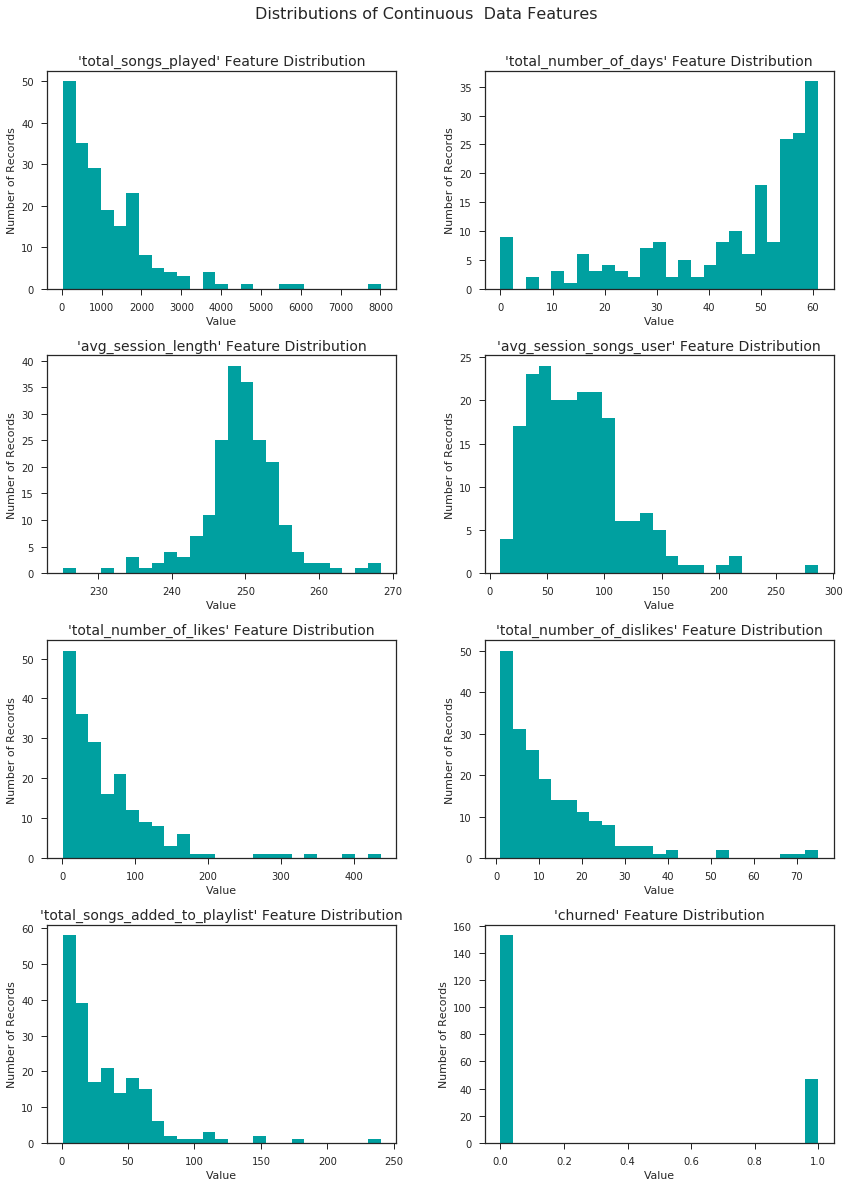

In [65]:
distribution(features_df, list_features)

> We can nicely see all our distributions here. Many of them are distributed right skewed, wheres average length pe session follows a symmetrical distribution. We know the impact of having skewed data in our model. We will need to normalize the dataset in order to nullify the impact of larger values over smaller values.

>Above, we have built our aggregated view of users containing several important features. Also, we have appended the churned label which will be our target variable. Now, that we are done with feature extraction, we will use this dataset for our
machine leanring problem of predicting the churn.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

> In Spark, we have two dominant machine learning module. Spark Mlib and Spark ML. Spark Mlib is extensively used as of now, but with future releases of Spark, Spark ML is slowly becoming the most powerful library.

In [66]:
#we will define our feature columns next
features_col = ["total_songs_played", "total_number_of_days", "avg_session_length", "avg_session_songs_user", "total_number_of_likes", \
                "total_number_of_dislikes", "total_songs_added_to_playlist"]

In [67]:
def feature_transform(data):
    '''
        This function will take the input data with continuous features, and first will apply VectorAssembler and then
        will apply StandardScaler to normalize the data set. 
        Function will return the dataframe with new column added as scaledFeatures as a vector.
    '''
    #initializing the assembler and transforming the data
    assembler = VectorAssembler(inputCols=features_col, outputCol="features_vector")
    
    #VectorAssembler will assemble all our features into a vector, and we will pass
    #that vector to our model for making prediction.
    features_vectored = assembler.transform(features_with_label)
    
    #initializing the standardscaler and then transforming data and creating a new column, scaledFeatures
    scaler = StandardScaler(inputCol="features_vector", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
    scalerModel = scaler.fit(features_vectored)
    df_scaled = scalerModel.transform(features_vectored)
    print("Transformed dataframe")
    df_scaled.printSchema()
    
    return df_scaled
    

In [68]:
df_scaled = feature_transform(features_with_label)

Transformed dataframe
root
 |-- userId: string (nullable = true)
 |-- total_songs_played: float (nullable = false)
 |-- total_number_of_days: float (nullable = true)
 |-- avg_session_length: float (nullable = true)
 |-- avg_session_songs_user: float (nullable = true)
 |-- total_number_of_likes: float (nullable = false)
 |-- total_number_of_dislikes: float (nullable = false)
 |-- total_songs_added_to_playlist: float (nullable = false)
 |-- churned: float (nullable = false)
 |-- features_vector: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



>We can see features_vector, scaledFeatures is added at the end, as a vector. Let's check some data .

In [69]:
df_scaled.head(1)

[Row(userId='100010', total_songs_played=275.0, total_number_of_days=44.0, avg_session_length=243.2837677001953, avg_session_songs_user=39.28571319580078, total_number_of_likes=17.0, total_number_of_dislikes=5.0, total_songs_added_to_playlist=7.0, churned=0.0, features_vector=DenseVector([275.0, 44.0, 243.2838, 39.2857, 17.0, 5.0, 7.0]), scaledFeatures=DenseVector([0.2463, 2.5782, 45.1153, 0.9502, 0.2552, 0.3781, 0.211]))]

In [70]:
df_scaled.select(['features_vector', 'scaledFeatures']).show()

+--------------------+--------------------+
|     features_vector|      scaledFeatures|
+--------------------+--------------------+
|[275.0,44.0,243.2...|[0.24625383230211...|
|[387.0,45.0,243.8...|[0.34654630218515...|
|[4079.0,60.0,250....|[3.65261593440120...|
|[2111.0,16.0,247....|[1.89033396359915...|
|[150.0,51.0,251.1...|[0.13432027216479...|
|[1914.0,55.0,251....|[1.71392667282272...|
|[2841.0,42.0,251....|[2.54402595480113...|
|[820.0,26.0,240.4...|[0.73428415450085...|
|[257.0,41.0,261.8...|[0.23013539964234...|
|[1928.0,50.0,251....|[1.72646323155810...|
|[1797.0,15.0,248....|[1.60915686053419...|
|[647.0,53.0,246.2...|[0.57936810727079...|
|[2070.0,56.0,249....|[1.85361975587411...|
|[3632.0,59.0,249....|[3.25234152335013...|
|[230.0,45.0,250.6...|[0.20595775065267...|
|[3028.0,44.0,251....|[2.71147856076657...|
|[1125.0,51.0,253....|[1.00740204123592...|
|[215.0,57.0,248.5...|[0.19252572343619...|
|[3573.0,60.0,248....|[3.19950888296531...|
|[377.0,21.0,251.7...|[0.3375916

In [ ]:
#we will use "scaledFeatures" as our input data and "churned" as our label for our model.
df_final = df_scaled.select(['scaledFeatures', 'churned'])

In [ ]:
df_final.printSchema()

In [72]:
#splitting the data into train and test using random split
train_data , test_data = df_scaled.randomSplit([0.8,0.2], seed = 42)
train_data.head(1)

[Row(userId='100010', total_songs_played=275.0, total_number_of_days=44.0, avg_session_length=243.2837677001953, avg_session_songs_user=39.28571319580078, total_number_of_likes=17.0, total_number_of_dislikes=5.0, total_songs_added_to_playlist=7.0, churned=0.0, features_vector=DenseVector([275.0, 44.0, 243.2838, 39.2857, 17.0, 5.0, 7.0]), scaledFeatures=DenseVector([0.2463, 2.5782, 45.1153, 0.9502, 0.2552, 0.3781, 0.211]))]

In [73]:
def train(classifier, train_data=train_data):
    ''' function will take as input the classifier name and return the trained model, results, along with training time 
        lr : LogisticRegression()
        rf : RandomForestClassifier()
        dt : DecisionTreeClassifier()
    
    '''
    if classifier == 'lr':
        #initializing logistic Regression for classification.
        print("Training the Logistic Regression Model...")
        start_time = time.time()
        lr = LogisticRegression(featuresCol ='scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = lr.fit(train_data)
        
        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
        
    elif classifier == 'rf':
        #initializing the Random Forest Classifier
        print("Training the Random Forest Model...")
        start_time = time.time()
        rf = RandomForestClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = rf.fit(train_data)
        
        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
        
    elif classifier == 'dt':
        #initializing the Decision Tree Classifier
        print("Training the Decision Tree Model...")
        start_time = time.time()
        dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = dt.fit(train_data)

        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
        
    elif classifier == 'gbt':
        #initializing the Gradient Boosted Tree Classifier
        print("Training the GBTClassifier Model...")
        start_time = time.time()
        dt = GBTClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = dt.fit(train_data)

        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
    
    else:
        print("Classifier not found. Please enter rf, lr, dt or gbt")
        
        
    return model, training_time

In [74]:
def test(model, test_data = test_data):
    '''
        This function will take as input the trained model, and do some predictions on the data, and return the 
        accuracy, areaUnderROC
    
    '''
    print("Testing model....")
    print("Statistics for model: {} ".format(model.featuresCol.parent.split('_')[0]))
    predictions = model.transform(test_data)
    
    #getting the area under ROC
    evaluator_areaUnderROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churned', metricName='areaUnderROC')
    areaUnderROC = evaluator_areaUnderROC.evaluate(predictions)
    print("Test Area Under ROC: " + str(areaUnderROC))
    print("Test Error = %g" % (1.0 - areaUnderROC))
    
    return predictions, areaUnderROC
   
    

# Model Selection & Evaluation

We will be training 3 popular machine learning algorithms for selecting the best model.

    1. LogisticRegression
    2. DecisionTreeClassifier
    3. RandomForestClassifier
    4. GradientBoostedTreeClassifier

As we have a binary label(churned), we can use ``BinaryClassificationEvaluator`` to evaluate our model. We can set the required column names in rawPredictionCol and labelCol Param and the metric in metricName Param. The default metric for this Evaluator is ``areaUnderROC``. 

Area Under The Curve ROC(Reciever Operating Characteristics) is area under the probability curve. It measures the degree of
separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the
x-axis.

TPR(Recall) = TP/ (TP+FP)

FPR(Precision) = TN/ (TN+FP)

<h4> Logistic Regression </h4>

In [75]:
#training the Logistic Regression Model
model_lr, train_time = train('lr')

Training the Logistic Regression Model...
That took 305.2978277206421 seconds.


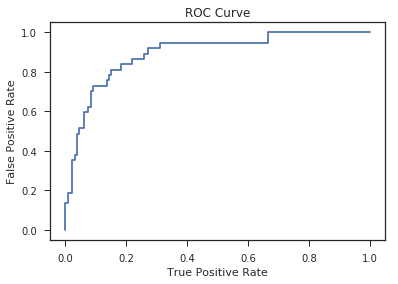

Training set areaUnderROC: 0.8923013923013933


In [76]:
#plotting the area under curve ROC for logistic regression. The roc is available in training summary.
training_summary = model_lr.summary
roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(training_summary.areaUnderROC))

In [77]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_lr)

Testing model....
Statistics for model: LogisticRegression 
Test Area Under ROC: 0.75
Test Error = 0.25


In [78]:
predictions.printSchema()

root
 |-- userId: string (nullable = true)
 |-- total_songs_played: float (nullable = false)
 |-- total_number_of_days: float (nullable = true)
 |-- avg_session_length: float (nullable = true)
 |-- avg_session_songs_user: float (nullable = true)
 |-- total_number_of_likes: float (nullable = false)
 |-- total_number_of_dislikes: float (nullable = false)
 |-- total_songs_added_to_playlist: float (nullable = false)
 |-- churned: float (nullable = false)
 |-- features_vector: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



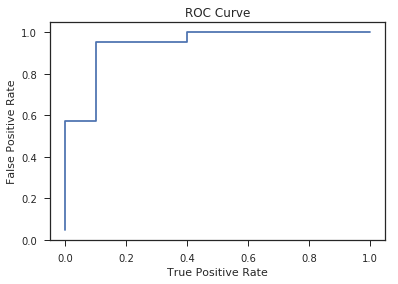

Testing set areaUnderROC: 0.75


In [79]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

<h4>Decision Tree Classifier </h4>

In [80]:
#training the decision tree classifier
model_dt, train_time = train('dt')

Training the Decision Tree Model...
That took 108.65027976036072 seconds.


In [81]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_dt)

Testing model....
Statistics for model: DecisionTreeClassifier 
Test Area Under ROC: 0.7761904761904761
Test Error = 0.22381


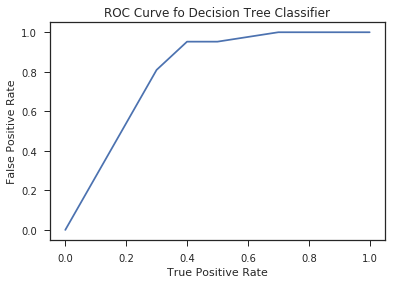

Testing set areaUnderROC: 0.7761904761904761


In [82]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve fo Decision Tree Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

<h4>Random Forest Classifier </h4>

In [83]:
#training the random forest classifier
model_rf, train_time = train('rf')

Training the Random Forest Model...
That took 123.3595883846283 seconds.


In [ ]:
#saving the model
model_rf.save('models/model_rf_2.model')

In [84]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_rf)

Testing model....
Statistics for model: RandomForestClassifier 
Test Area Under ROC: 0.7761904761904761
Test Error = 0.22381


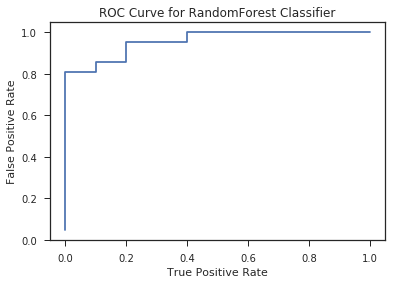

Testing set areaUnderROC: 0.7761904761904761


In [85]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for RandomForest Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

**GradientBoostedTreeClassifier**

In [86]:
#training the gradient boosting classifier
model_gbt, train_time = train('gbt')

Training the GBTClassifier Model...
That took 383.97645020484924 seconds.


In [87]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_gbt)

Testing model....
Statistics for model: GBTClassifier 
Test Area Under ROC: 0.7761904761904761
Test Error = 0.22381


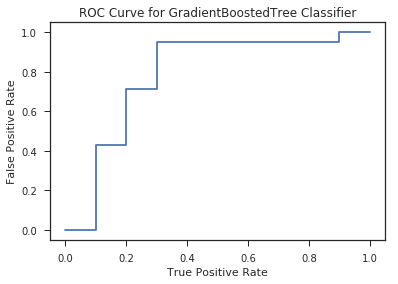

Testing set areaUnderROC: 0.7761904761904761


In [88]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for GradientBoostedTree Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

In [108]:
importantecs = model_rf.featureImportances

array([1, 0, 6, 5, 3, 4, 2])

In [101]:
indices = np.argsort(importantecs)[::-1]

array([1, 0, 6, 5, 3, 4, 2])

In [121]:
#the feature importance is
for i, c in enumerate(np.array(train_data.columns)):
    if i in indices and i > 0:
        print(i,c)

1 total_songs_played
2 total_number_of_days
3 avg_session_length
4 avg_session_songs_user
5 total_number_of_likes
6 total_number_of_dislikes


# Model Tuning

> From above analysis, we could clearly see GradientBoostedTree is performing best compared to LogisticRegression, RandomForest and DecisionTree.
For, Logistic Regression the training time is significantly huge as well. Decision Tree without any parameters outperformed RandomForestClassifier.
GradientBoosted Tree classifier uses an ensemble of decision trees. In terms of performance and accuracy, this model is best one we will select for further tuning.

>We will use RandomForest and GBT to perform cross-validation.

>cross-validation over a grid of parameters is expensive. E.g., the parameter grid has 2 values for numTrees and 4 values for rf.maxDepth, and CrossValidator uses 3 folds. This multiplies out to (2×4)×3=24 different models being trained. In realistic settings, it can be common to try many more parameters and use more folds. In other words, using CrossValidator can be very expensive. However, it is also a well-established method for choosing parameters which is more statistically sound than heuristic hand-tuning.

In [122]:
#in order to use in cross validation, we need to rename our target and features to a label, features. Same for test set.
train_data_cv = train_data.withColumnRenamed("churned", "label").withColumnRenamed("scaledFeatures", 'features')

In [123]:
test_data_cv = test_data.withColumnRenamed("churned", "label").withColumnRenamed("scaledFeatures", 'features')

In [124]:
#Random Forest Classifier
#we will now create a pipeline for estimator wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for rf.numTrees and 4 values for rf.maxDepth,
# this grid will have 2 x 3 = 8 parameter settings for CrossValidator to choose from for 3 folds.

numFolds = 3

rf = RandomForestClassifier()
evaluator = BinaryClassificationEvaluator()  

paramGrid = (ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20])\
    .addGrid(rf.maxDepth, [2, 4, 6])  \
    .build())

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

print("Training the RF over crossval...")
start_time = time.time()

model_rf_cv = crossval.fit(train_data_cv)

print("training complete")
print("That took %s seconds." % (time.time() - start_time))

Training the RF over crossval...
training complete
That took 774.6989688873291 seconds.


In [131]:
def cross_val_test(model, test_data = test_data_cv):
    '''
        This function will take as input the trained model, and do some predictions on the data, and return the 
        accuracy, areaUnderROC
    
    '''
    print("Testing model for cross validation....")
    predictions = model.transform(test_data_cv)
    
    #getting the area under ROC
    evaluator_areaUnderROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
    areaUnderROC = evaluator_areaUnderROC.evaluate(predictions)
    print("Test Area Under ROC: " + str(areaUnderROC))
    print("Test Error = %g" % (1.0 - areaUnderROC))
    
    return predictions, areaUnderROC

In [132]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction, areaUnderROC = cross_val_test(model_rf_cv)

Testing model for cross validation....
Test Area Under ROC: 0.726190476190476
Test Error = 0.27381


In [133]:
model_rf_cv.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_c38b8cd5a43c) with 10 trees

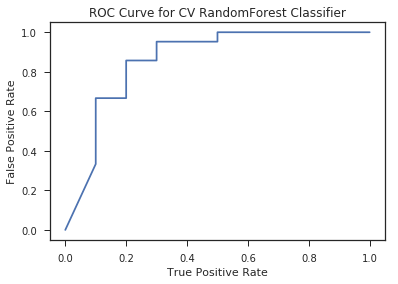

Testing set areaUnderROC: 0.726190476190476


In [135]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = prediction.select(['probability', 'label'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for CV RandomForest Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

>Even after many tries, the cross-validation could not improve the model. Similar operation was performed on GradientBoosted Tree, but that operation took more than 2 hrs and the result could not improve either.

>In this scenario, we would go with our best model as the default RandomForestClassifier.

# Conclusion

>We performed several ML models on our event log data and plotted the AUCROC curve for each of the models. 
We found out, the Random Tree Classifier to be the most efficient model out of all. We also performed cross-validation for 
model tuning. Finally, I wrote a blog post with my findings in medium.com.